# PLRデータ分析例

PLRに保存したデータの取得例です。

本環境は [Jupyter Notebook](https://jupyter.org/) の形で構成されており、[Pythonスクリプト](https://www.python.jp/)を用いて記述しています。

ライブラリは公式イメージ [jupyter/scipy-notebook](https://jupyter-docker-stacks.readthedocs.io/en/latest/using/selecting.html#jupyter-scipy-notebook) のものがインストールされています。

# チャンネルの取得

処理したいデータが格納されたチャンネルを取得します。cogtask.meにより格納されたデータを処理したい場合は、 `cog-pds-log` となります。


> Jupyter Notebook Serverの起動直後など、実行がなかなか終わらない状態になる可能性があります。
> 実行状態が `[*]` のまま先に進まない場合は 中断(■) を押して一旦中断し、再度実行してみてください。

In [1]:
import asyncio
from plrfs.rpc_client import PLRFSClient

# クライアントライブラリを初期化
loop = asyncio.get_event_loop()

client = await PLRFSClient(loop).connect()

# チャンネル一覧を取得
channels = await client.get_files([])
for ch in channels:
    print('Channel', repr(ch['name']))

Channel 'family'
Channel 'coworkers'
Channel 'friends'
Channel '共有テスト'
Channel 'Garmin Connect活動記録'
Channel 'Cloze Test学習記録'
Channel 'cog-pds-log'
Channel 'cog-pds-log(from googleDrive:yazawa-satoshi@g.ecc.u-tokyo.ac.jp)'


参照したいチャンネル名を以下に記述します。

In [2]:
channel_name = 'cog-pds-log'
channel_name

'cog-pds-log'

In [3]:
channels = await client.get_files([])
cogtask_me_chs = [c for c in channels if c['name'] == channel_name]
assert len(cogtask_me_chs) > 0, 'cogtask.meのチャンネルが見つかりません。'
cogtask_me_ch = cogtask_me_chs[0]
cogtask_me_ch

{'kind': 'folder', 'id': '20210406135701_CwTF', 'name': 'cog-pds-log'}

データの読み込みは `PLRFSClient`から実施できます。これは以下のような関数を持っています。

In [4]:
help(client)

Help on PLRFSClient in module plrfs.rpc_client object:

class PLRFSClient(builtins.object)
 |  PLRFSClient(loop)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, loop)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  async connect(self)
 |  
 |  async get_file(self, path)
 |  
 |  async get_files(self, path)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



ファイルシステムを模した構造になっていて、 `client.get_files` で指定したチャンネル、アイテムの配下のアイテム一覧を取得することができます。また、`client.get_file` で指定したチャンネル、アイテムの配下のデータを取得することができます。


# 数字記憶タスクデータの取得

試しに、チャンネルから数字記憶タスクデータを取り出してみましょう。

In [5]:
# https://cogtask.me/t/Z1WcnPbeOCmMtYIhXyOG ならば、 Z1WcnPbeOCmMtYIhXyOG
task_id = 'CnyygxrubaIb23W9BGP9'
task_id

'CnyygxrubaIb23W9BGP9'

まず、分析対象としたいタスクのIDに合致するログデータを抽出してみます。

In [6]:
import json
import pandas as pd

timeline_item_data = []
# チャンネル内のアイテムを取得する
timeline_items = await client.get_files([cogtask_me_ch['id']])

for item in timeline_items:
    print('Processing...', item['id'])
    # アイテムのプロパティを取得する
    timeline_properties = await client.get_files([cogtask_me_ch['id'], item['id']])
    if 'cogPDSJSON' not in [p['name'] for p in timeline_properties]:
        continue
    
    # プロパティごとのデータを取得する
    cogPDSJSON = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cogPDSJSON'][0]])
    cogPDSJSONDict = json.loads(cogPDSJSON['content'])
    if 'meta' in cogPDSJSONDict and 'task' in cogPDSJSONDict['meta'] and cogPDSJSONDict['meta']['task']['id'] == task_id:
        assert 'cnt' in [p['name'] for p in timeline_properties]
        assert 'begin' in [p['name'] for p in timeline_properties]
        summary = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cnt'][0]])
        begin = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'begin'][0]])
        if 'cogPDSUser' in [p['name'] for p in timeline_properties]:
            cogPDSUser = await client.get_file([cogtask_me_ch['id'], item['id'], [p['id'] for p in timeline_properties if p['name'] == 'cogPDSUser'][0]])
        else:
            cogPDSUser = None
        timeline_item_data.append((summary['content'].decode('utf8'), begin['content'].decode('utf8'),
                                   cogPDSUser['content'].decode('utf8') if cogPDSUser is not None else None, json.loads(cogPDSJSON['content'])))

df = pd.DataFrame(timeline_item_data, columns=['Summary', 'Time', 'User', 'Detail'])
df

Processing... #20210406224204_dTJy
Processing... #20210406224206_QA95
Processing... #20210406230009_fhsd
Processing... #20210406230003_EknP
Processing... #20210406225911_WCmC
Processing... #20210406230006_8yVF
Processing... #20210407010607_FEja
Processing... #20210407010804_hdRo
Processing... #20210407011104_UzZ5
Processing... #20210407011404_jbSi
Processing... #20210407012509_e5HS
Processing... #20210407012604_uFFV
Processing... #20210520010909_Cq8d
Processing... #20210520010905_mr9s
Processing... #20210407135905_HQPh
Processing... #20210408032308_Sw7p
Processing... #20210408032304_oUp5
Processing... #20210422020703_RGI1
Processing... #20210429213205_HhVe
Processing... #20210510074103_yDbD
Processing... #20210511023003_wAqO
Processing... #20210513051402_P0ae
Processing... #20210513052009_ED-2
Processing... #20210513052003_3ml7
Processing... #20210513052908_E1k5
Processing... #20210513052903_cU1t
Processing... #20210513134109_d4uT
Processing... #20210513134015_oCiE
Processing... #20210

,Summary,Time,User,Detail
0,数字記憶タスク（授業使用）: 数字記憶タスクを 1 回実施しました。(平均点 6 点),2021-06-28T12:19:31.265Z,None,{'meta': {'task': {'id': 'CnyygxrubaIb23W9BGP9...
1,数字記憶タスク（授業使用）: 数字記憶タスクを 2 回実施しました。(平均点 8 点),2021-06-28T12:51:22.967Z,None,{'meta': {'task': {'id': 'CnyygxrubaIb23W9BGP9...


このようにして、Personary上のデータをメモリに読み込むことができます。これらの内容を**暗号化等をかけていないファイル等に出力する際は十分に取り扱いに注意**してください。

各データの `Detail` にはログが記録されています。

In [7]:
# .values[-1]でlist最後のデータを参照
df['Detail'].values[-1]

{'meta': {'task': {'id': 'CnyygxrubaIb23W9BGP9', 'title': '数字記憶タスク（授業使用）'},
  'started': 1624884603499,
  'recorded': 1624884682965,
  'finished': 1624884682965,
  'duration': 79466},
 'data': [{'finished': 1624884631549,
   'index': 0,
   'score': 10,
   'answers': {'0': {'time': 1624884627123, 'value': 0, 'correct': 0},
    '1': {'time': 1624884627789, 'value': 5, 'correct': 5},
    '2': {'time': 1624884628239, 'value': 9, 'correct': 9},
    '3': {'time': 1624884628466, 'value': 2, 'correct': 2},
    '4': {'time': 1624884628721, 'value': 9, 'correct': 9},
    '5': {'time': 1624884628834, 'value': 9, 'correct': 9},
    '6': {'time': 1624884629125, 'value': 7, 'correct': 7},
    '7': {'time': 1624884629369, 'value': 9, 'correct': 9},
    '8': {'time': 1624884629603, 'value': 1, 'correct': 1},
    '9': {'time': 1624884630064, 'value': 7, 'correct': 7}}},
  {'finished': 1624884680480,
   'index': 1,
   'score': 6,
   'answers': {'0': {'time': 1624884674008, 'value': 8, 'correct': 8},
   

# 分析例: スコア変化

スコアがどのように変化しているのかを抽出してみます。

1つのログには複数回の回答が記録されている可能性がありますので、これを考慮してデータをまとめてみます。

In [9]:
from datetime import datetime, timezone

# 試行をまとめたPandas DataFrameを返す
def log_to_trials(log):
    trials = []
    started = log['meta']['started']
    for trial in log['data']:
        trials.append((
            # おまじない: utcfromtimestampは1970/1/1からの経過時間を秒で扱う / cogtask.meのデータは1970/1/1からの経過時間をミリ秒で扱う
            datetime.fromtimestamp(started / 1000, tz=timezone.utc),
            datetime.fromtimestamp(trial['finished'] / 1000, tz=timezone.utc),
            trial['score']
        ))
        # この問題の終了時刻を次の試行の開始時刻とみなす
        started = trial['finished']
    return pd.DataFrame(trials, columns=['Start', 'Finish', 'Score'])

log_to_trials(df['Detail'].values[-1])

,Start,Finish,Score
0,2021-06-28 12:50:03.499000+00:00,2021-06-28 12:50:31.549000+00:00,10
1,2021-06-28 12:50:31.549000+00:00,2021-06-28 12:51:20.480000+00:00,6


In [10]:
trials_dfs = []
for user, detail in df[['User', 'Detail']].values:
    trials_df = log_to_trials(detail)
    trials_df['User'] = user
    trials_dfs.append(trials_df)
trials_df = pd.concat(trials_dfs)
trials_df

,Start,Finish,Score,User
0,2021-06-28 12:19:02.211000+00:00,2021-06-28 12:19:27.720000+00:00,6,None
0,2021-06-28 12:50:03.499000+00:00,2021-06-28 12:50:31.549000+00:00,10,None
1,2021-06-28 12:50:31.549000+00:00,2021-06-28 12:51:20.480000+00:00,6,None


この例では、 `User` カラムにユーザ識別子を入れてあります。この値はcogtask.meによって振られるもので、タスク内での識別に利用できます。（セキュリティの観点で、PLRのデータだけでは、タスク間の名寄せはできないようにしています。）

> 個人(自分自身)のデータはUser = Noneになります。

スコアの平均値を計算したい場合は `.mean()` を使う。

In [16]:
# pd.isnullでUser=Noneのデータのみ抽出、 [['カラム名']] で特定カラムだけ抽出
trials_df[pd.isnull(trials_df['User'])][['Score']].mean()

Score    7.333333
dtype: float64

実施時間とスコアの関係をグラフで見てみよう。グラフを使う場合は以下のおまじないを実行します。

In [17]:
%matplotlib inline

pandas DataFrameの `.plot` でグラフを描くことができます。

<AxesSubplot:xlabel='Start'>

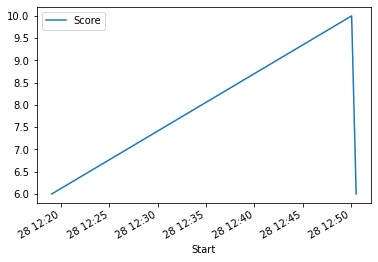

In [18]:
trials_df.set_index('Start')[['Score']].plot()